In [41]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


In [18]:

# Loading the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Augmening Data
    transforms.RandomCrop(32, padding=4), # Augmenting Data
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Defining the residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [21]:
# Defining the base ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [22]:
# Defining ResNet-18
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [23]:
# Setting up training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 100
patience = 8
best_val_loss = 999999

In [24]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(valloader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


Epoch 1/100, Training Loss: 1.5824, Training Accuracy: 0.4307, Validation Loss: 1.2905, Validation Accuracy: 0.5307
Epoch 2/100, Training Loss: 1.1593, Training Accuracy: 0.5899, Validation Loss: 1.1245, Validation Accuracy: 0.6045
Epoch 3/100, Training Loss: 0.9574, Training Accuracy: 0.6598, Validation Loss: 0.9681, Validation Accuracy: 0.6704
Epoch 4/100, Training Loss: 0.8361, Training Accuracy: 0.7086, Validation Loss: 0.8551, Validation Accuracy: 0.7009
Epoch 5/100, Training Loss: 0.7508, Training Accuracy: 0.7387, Validation Loss: 0.7411, Validation Accuracy: 0.7435
Epoch 6/100, Training Loss: 0.6824, Training Accuracy: 0.7629, Validation Loss: 0.7340, Validation Accuracy: 0.7443
Epoch 7/100, Training Loss: 0.6310, Training Accuracy: 0.7811, Validation Loss: 0.6655, Validation Accuracy: 0.7765
Epoch 8/100, Training Loss: 0.5861, Training Accuracy: 0.7964, Validation Loss: 0.6684, Validation Accuracy: 0.7696
Epoch 9/100, Training Loss: 0.5490, Training Accuracy: 0.8088, Validatio

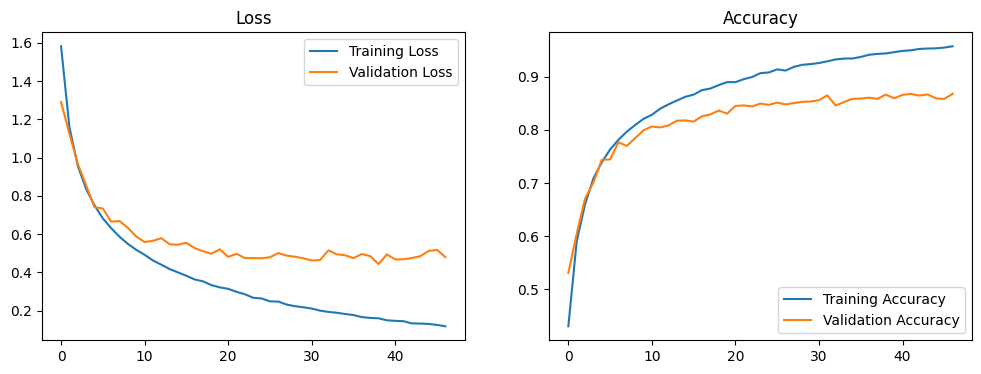

In [25]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


In [39]:
# Evaluating the model on test data
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().detach().numpy())  # Move to CPU before converting to numpy
            ground_truth.extend(labels.cpu().detach().numpy())    # Move to CPU before converting to numpy
    accuracy = correct / total * 100

    conf_matrix = confusion_matrix(ground_truth, predictions)
    return accuracy, conf_matrix


accuracy, conf_matrix = test(model, testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 86.29%


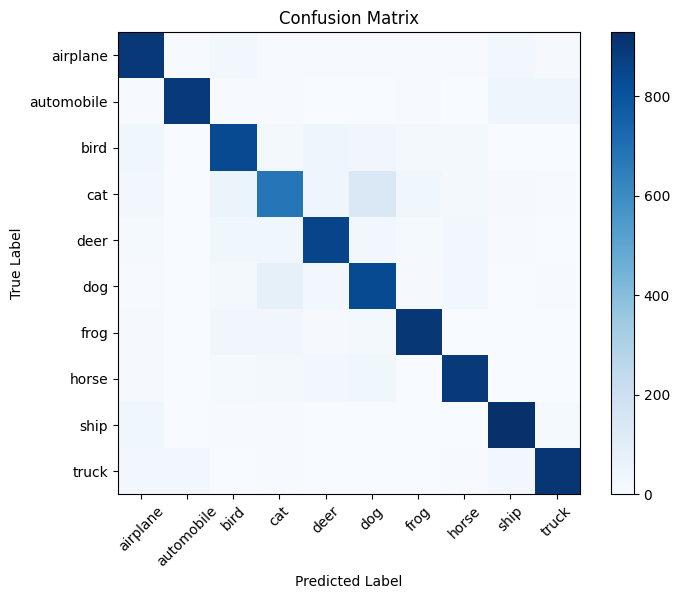

Confusion Matrix:
[[899   4  29   7   4   4   7   7  29  10]
 [  7 895   5   4   0   2   6   1  38  42]
 [ 36   1 834  20  39  30  20  15   2   3]
 [ 24   2  50 681  42 137  33  17   8   6]
 [ 11   0  33  36 854  23  14  23   6   0]
 [  7   0  17  78  25 833   9  25   1   5]
 [  8   1  30  32   9  16 902   1   0   1]
 [  9   2  13  16  25  35   1 895   1   3]
 [ 36   3   7   6   1   2   1   1 929  14]
 [ 26  25   3   7   1   1   2   5  23 907]]


In [42]:
# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)
